- combine all three rews
- second markov chain
- convince selves of block height
- gamma

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

In [393]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, E  = sp.symbols('a b x g p E')

In [394]:
p0fail = (1-p)*p1*sp.exp(-x) / (a*p*(1-sp.exp(-b+E))+a*(1-p)*(1-sp.exp(-b)))
p0fail

p_1*(1 - p)*exp(-x)/(a*p*(1 - exp(E - b)) + a*(1 - p)*(1 - exp(-b)))

In [395]:
f0failHi = a
f0failLo = a*sp.exp(-b+x)+a**2*(1-sp.exp(-b+x)) + a*(1-a)*(1-sp.exp(-b+x))*(a+(1-a)*g)
f0failLo

a**2*(1 - exp(-b + x)) + a*(1 - a)*(1 - exp(-b + x))*(a + g*(1 - a)) + a*exp(-b + x)

In [396]:
p1_solved = 1/(1/(a*p*(1-sp.exp(-b+E)) + a*(1-p)*(1-sp.exp(-b))) + 1 + (1-a)/(1-2*a))
p1_solved

1/(1 + 1/(a*p*(1 - exp(E - b)) + a*(1 - p)*(1 - exp(-b))) + (1 - a)/(1 - 2*a))

In [397]:
loIntegrandFail = sp.simplify(p0fail * f0failLo)
loIntegralFail  = sp.simplify(sp.integrate(loIntegrandFail, (x, 0, b)))

In [398]:
hiIntegrandFail = sp.simplify(p0fail * f0failHi)
hiIntegralFail  = sp.simplify(sp.integrate(hiIntegrandFail, (x, b, sp.oo)))

In [399]:
p0success = p*p1*sp.exp(-x) / (a*p*(1-sp.exp(-b+E))+a*(1-p)*(1-sp.exp(-b)))
p0success

p*p_1*exp(-x)/(a*p*(1 - exp(E - b)) + a*(1 - p)*(1 - exp(-b)))

In [400]:
f0successHi = a
f0successLo = a*sp.exp(-b+E+x)+a**2*(1-sp.exp(-b+E+x)) + a*(1-a)*(1-sp.exp(-b+E+x))*(a+(1-a)*g)
f0successLo

a**2*(1 - exp(E - b + x)) + a*(1 - a)*(1 - exp(E - b + x))*(a + g*(1 - a)) + a*exp(E - b + x)

In [401]:
loIntegrandSuccess = sp.simplify(p0success * f0successLo)
loIntegralSuccess  = sp.simplify(sp.integrate(loIntegrandSuccess, (x, 0, b-E)))

In [402]:
hiIntegrandSuccess = sp.simplify(p0success * f0successHi)
hiIntegralSuccess  = sp.simplify(sp.integrate(hiIntegrandSuccess, (x, b-E, sp.oo)))

In [403]:
full = loIntegralFail + hiIntegralFail + loIntegralSuccess + hiIntegralSuccess + p1*(3*a - a**2 + 2*a**2/(1-2*a))
full

p_1*(-a**2 + 2*a**2/(1 - 2*a) + 3*a) + Piecewise((p_1*(p - 1)/(p*exp(E) - p - exp(b) + 1), Ne(-p*exp(E) + p + exp(b), 1)), (Piecewise((nan, Eq(p_1*(p - 1)/(p*exp(E) - p - exp(b) + 1), 0)), (p_1*(p - 1)*(-b*Abs(p_1*(p - 1)/(p*exp(E) - p - exp(b) + 1)) + oo)/((p*exp(E) - p - exp(b) + 1)*Abs(p_1*(p - 1)/(p*exp(E) - p - exp(b) + 1))), True)), True)) + Piecewise((p_1*(-a**2*g*p + a**2*g + a**2*p - a**2 + 2*a*g*p - 2*a*g - 2*a*p + 2*a - b*(a**2*g*p - a**2*g - a**2*p + a**2 - 2*a*g*p + 2*a*g + 2*a*p - 2*a + g*p - g - p + 1) - g*p + g + (a**2*g*p - a**2*g - a**2*p + a**2 - 2*a*g*p + 2*a*g + 2*a*p - 2*a + g*p - g)*exp(b))/(p*exp(E) - p - exp(b) + 1), Ne(-p*exp(E) + p + exp(b), 1)), (b*p_1*(p - 1)/(p*exp(E) - p - exp(b) + 1), True)) + Piecewise((p*p_1*(-(E - b)*(a**2*g - a**2 - 2*a*g + 2*a + g - 1)*exp(E) + (-a**2*g + a**2 + 2*a*g - 2*a - g)*exp(b) + (a**2*g - a**2 - 2*a*g + 2*a + g)*exp(E))/(p*exp(E) - p - exp(b) + 1), Ne(-p*exp(E) + p + exp(b), 1)), (p*p_1*(E - b)*(a**2*g - a**2 - 2*a*g + 2*a 

In [404]:
p1_solved = 1/(1/(a*p*(1-sp.exp(-b+E)) + a*(1-p)*(1-sp.exp(-b))) + 1 + (1-a)/(1-2*a))
p1_solved

1/(1 + 1/(a*p*(1 - exp(E - b)) + a*(1 - p)*(1 - exp(-b))) + (1 - a)/(1 - 2*a))

In [405]:
fullLambda = sp.lambdify((a, b, g, p, E), full.evalf(subs={p1:p1_solved}))
fullLambda

<function _lambdifygenerated(a, b, g, p, E)>

In [406]:
alphas = [0.2, 0.25, 0.3, 0.35, 0.4]
betas  = np.arange(1, 4, 0.01)
ps     = [0, 0.2, 0.5, 0.8] # using E=1

In [407]:
theoRes = []
for a in alphas:
    temp1 = []
    for b in betas:
        temp2 = []
        for p in ps:
            temp2.append(fullLambda(a=a, b=b, g=0.0, p=p, E=1.))
#             temp2.append(fullLambda(a=a, b=b, g=0.0, p=0.1, E=0.))
        temp1.append(temp2)
    theoRes.append(temp1)
theoRes = np.array(theoRes)
theoRes.shape

<lambdifygenerated-15>:2: RuntimeWarning: invalid value encountered in double_scalars
  return select([not_equal(-p*exp(E) + p + exp(b), 1),True], [(p - 1.0)/((1.0 + (a*p*(1.0 - exp(E - b)) + a*(1.0 - p)*(1.0 - exp(-b)))**(-1.0) + (1.0 - a)/(1.0 - 2.0*a))*(p*exp(E) - p - exp(b) + 1.0)),select([equal((p - 1)/((1 + (a*p*(1 - exp(E - b)) + a*(1 - p)*(1 - exp(-b)))**(-1.0) + (1 - a)/(1 - 2*a))*(p*exp(E) - p - exp(b) + 1)), 0),True], [nan,(p - 1.0)*(-b*abs((p - 1)/(((a - 1)/(2*a - 1) + 1 - 1/(a*p*(exp(E - b) - 1) + a*(1 - exp(-b))*(p - 1)))*(p*exp(E) - p - exp(b) + 1))) + inf)/((1.0 + (a*p*(1.0 - exp(E - b)) + a*(1.0 - p)*(1.0 - exp(-b)))**(-1.0) + (1.0 - a)/(1.0 - 2.0*a))*(p*exp(E) - p - exp(b) + 1.0)*abs((p - 1)/(((a - 1)/(2*a - 1) + 1 - 1/(a*p*(exp(E - b) - 1) + a*(1 - exp(-b))*(p - 1)))*(p*exp(E) - p - exp(b) + 1))))], default=nan)], default=nan) + select([not_equal(-p*exp(E) + p + exp(b), 1),True], [(-a**2*g*p + a**2*g + a**2*p - a**2 + 2.0*a*g*p - 2.0*a*g - 2.0*a*p + 2.0*a - b*(a**2*g

(5, 300, 4)

# SIM FOR LINEAR REWARD UNDER BERNOULLI

In [366]:
def simLinearRewardBernoulli(a, b, p, E, n):
    gamma = 0
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    honestBern = 0
    attackBern = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0
    prevBern   = 0
    for _ in range(n):
        attBlock = np.random.binomial(1, a)
        execRews = np.random.exponential()
        bernRews = np.random.binomial(1, p=p)
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if bernRews and execRews < (b-E):
                    state      = [1,0]
                    lastAttBlc = curTime
                    prevBern   = bernRews
                elif not bernRews and execRews < b:
                    state = [1,0]
                    lastAttBlc = curTime
                else:
                    attackBlcs += 1
                    attackRews += execRews
                    attackBern += bernRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                honestBern += bernRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
                attackBern += bernRews + prevBern
                prevBern   = 0
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                nextBern      = np.random.binomial(1, p=p)
                if sample < a:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                    attackBern += (prevBern + nextBern)
                elif sample <= a + ((1-a)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                    attackBern += (prevBern + nextBern)
                    honestBern += nextBern
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                    honestBern += (bernRews + nextBern)
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                prevBern    = 0
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            if state[0] < 2:
                raise KeyError("here")
            attackBern += (state[0]-2) * p * E
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, a)
            execRews = np.random.exponential()
            bernRews = np.random.binomial(1, p=p)
            curTime += execRews
            if attBlock:
                attackBlcs += 1
                attackRews += (remRews + execRews)
                attackBern += bernRews
            else:
                honestBlcs += 1
                honestRews += (remRews + execRews)
                honestBern += bernRews

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]
 
    return honestRews, attackRews

In [367]:
alphas = [0.2, 0.25, 0.3, 0.35, 0.4]
betas  = np.arange(1, 4, 0.01)
ps     = [0, 0.2, 0.5, 0.8] # using E=1

In [368]:
simBetas  = np.arange(1, 4, 0.25)
simBetas

array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
       3.75])

In [369]:
simsRes = []
for a in alphas:
    temp1 = []
    for b in tqdm(simBetas):
        temp2 = []
        for p in ps:
            hb, ab = simLinearRewardBernoulli(a=a, b=b, p=p, E=1, n=int(1e5))
            temp2.append(ab/(ab+hb))
        temp1.append(temp2)
    simsRes.append(temp1)
simsRes = np.array(simsRes)
simsRes.shape

100%|██████████| 12/12 [00:28<00:00,  2.34s/it]


(5, 12, 4)

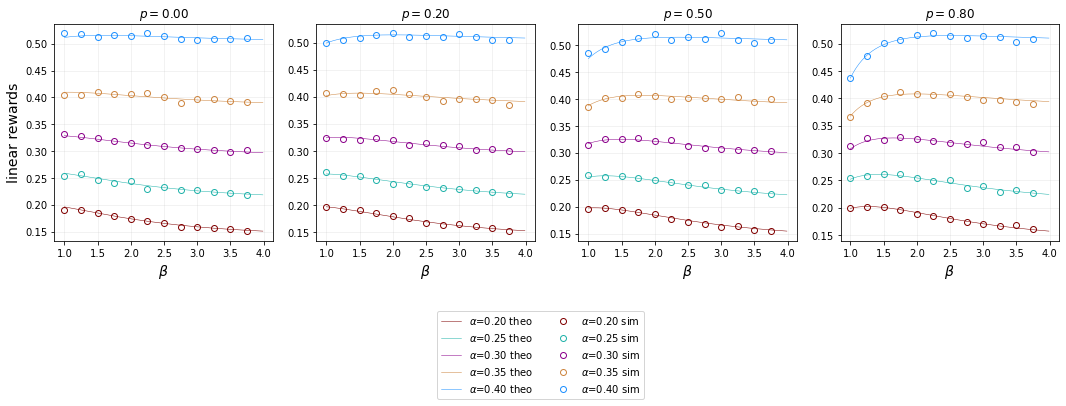

In [408]:
f, axarr = plt.subplots(ncols=4, figsize=(18,4))

colors = ['maroon', 'lightseagreen', 'darkmagenta', 'peru', 'dodgerblue'] 
handles, labels = [], []

for i in range(4):
    ax = axarr[i]
    for j, a in enumerate(alphas):
        line, = ax.plot(betas, theoRes[j,:,i], linewidth=0.5, color=colors[j], 
                        label=r'$\alpha$={:0.2f} theo'.format(a))
        if i == 0:
            handles.append(line)
            labels.append(r'$\alpha$={:0.2f} theo'.format(a))

for i in range(4):
    ax = axarr[i]
    for j, a in enumerate(alphas):
        marker, = ax.plot(simBetas, simsRes[j,:,i], marker='o', color=colors[j], linestyle='none', 
                          fillstyle='none', label=r'$\alpha$={:0.2f} sim'.format(a))
        if i == 0:
            handles.append(marker)
            labels.append(r'$\alpha$={:0.2f} sim'.format(a))


for i, ax in enumerate(axarr):
    ax.grid(alpha=0.2)
    ax.set_xlabel(r'$\beta$', size=14)
    ax.set_title(r'$p=${:0.2f}'.format(ps[i]))

axarr[0].set_ylabel(r'linear rewards', size=14)
f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# SIM for block reward under bernoulli

In [25]:
def p1Bernoulli(a, b, p, E):
    expr = 1/(a*p*(1-np.exp(-b+E))+a*(1-p)*(1-np.exp(-b)))
    return 1/(expr+1+(1-a)/(1-2*a))

def honestBlocksBernoulli(a, b, p, E):
    expr1 = (1-a)/(a*p*(1-np.exp(-b+E))+a*(1-p)*(1-np.exp(-b)))
    expr2 = expr1 + 2*((1-a)**2) + a*(1-a)
    return expr2

def attackBlocksBernoulli(a, b, p, E):
    expr1 = (a*p*np.exp(-b+E)+a*(1-p)*np.exp(-b))/(a*p*(1-np.exp(-b+E))+a*(1-p)*(1-np.exp(-b)))
    expr2 = (1-a)*(a**3) / ((1-2*a)*((1-a)**2))
    expr3 = expr1 + 2*a*(1-a) + a**2 + a*(2-a)/(1-a) + expr2
    return expr3

def fixedRewBernoulli(a, b, p, E):
    A = attackBlocksBernoulli(a, b, p, E)
    H = honestBlocksBernoulli(a, b, p, E)
    return A/(A+H)

In [26]:
def honestBlocksBeta(a, b, gamma=1):
    exp1 = (1-a) / (a * (1 - np.exp(-b)))
    exp2 = np.power(1-a, 2) * (2-gamma)
    exp3 = a * (1-a)
    return (exp1 + exp2 + exp3)

def atttackBlocksBeta(a, b, gamma=1):
    exp1 = np.exp(-b) / (a * (1-np.exp(-b)))
    exp2 = 2 - a + ((2-a)/(1-a))
    exp3 = np.power(1-a, 2) * gamma / a
    exp4 = np.power(a,2) / ((1-2*a)*(1-a))
    return a * (exp1 + exp2 + exp3 + exp4)

def fixedRewBeta(a, b, gamma=1):
    return atttackBlocksBeta(a,b,gamma) / (atttackBlocksBeta(a,b,gamma) + honestBlocksBeta(a,b,gamma))

In [28]:
p1Bernoulli(a=0.3, b=5, p=0.5, E=1)

0.1632488076308718

In [29]:
fixedRewBernoulli(a=0.33, b=1, p=0.5, E=1)

0.3288251553752685

In [30]:
def simFixedRewardBernoulli(a, b, p, E, n):
    gamma = 0
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    honestBern = 0
    attackBern = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0

    for _ in range(n):
        attBlock = np.random.binomial(1, a)
        execRews = np.random.exponential()
        bernRews = np.random.binomial(1, p=p)
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if bernRews and execRews < (b-E):
                    state = [1,0]
                    lastAttBlc = curTime
                elif not bernRews and execRews < b:
                    state = [1,0]
                    lastAttBlc = curTime
                else:
                    attackBlcs += 1
                    attackRews += execRews
                    attackBern += bernRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                honestBern += bernRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                nextBern      = np.random.binomial(1, p=p)
                if sample < a:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                    attackBern += (bernRews + nextBern)
                elif sample <= a + ((1-a)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                    attackBern += bernRews
                    honestBern += nextBern
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                    honestBern += (bernRews + nextBern)
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, a)
            execRews = np.random.exponential()
            curTime += execRews
            if attBlock:
                attackBlcs += 1
                attackRews += (remRews + execRews)
            else:
                honestBlcs += 1
                honestRews += (remRews + execRews)

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]
 
    return honestBlcs, attackBlcs

In [31]:
hB, aB = simFixedRewardBernoulli(a=0.35, b=2, p=0.5, E=1, n=int(1e5))
aB/(aB+hB)

0.36378517505411545

In [32]:
fixedRewBernoulli(a=0.35, b=2, p=0.5, E=1)

0.3626284385640299

In [35]:
alphas = [0.2, 0.25, 0.3, 0.35, 0.4]
betas  = np.arange(1, 4, 0.01)
ps     = [0, 0.2, 0.5, 0.8] # using E=1

In [36]:
theoRes = []
for a in alphas:
    temp1 = []
    for b in betas:
        temp2 = []
        for p in ps:
            temp2.append(fixedRewBernoulli(a=a, b=b, p=p, E=1))
        temp1.append(temp2)
    theoRes.append(temp1)
theoRes = np.array(theoRes)
theoRes.shape

(5, 300, 4)

In [37]:
simBetas  = np.arange(1, 4, 0.25)
simBetas

array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
       3.75])

In [40]:
simsRes = []
for a in alphas:
    temp1 = []
    for b in tqdm(simBetas):
        temp2 = []
        for p in ps:
            hb, ab = simFixedRewardBernoulli(a=a, b=b, p=p, E=1, n=int(1e5))
            temp2.append(ab/(ab+hb))
        temp1.append(temp2)
    simsRes.append(temp1)
simsRes = np.array(simsRes)
simsRes.shape

100%|██████████| 12/12 [00:26<00:00,  2.20s/it]


(5, 12, 4)

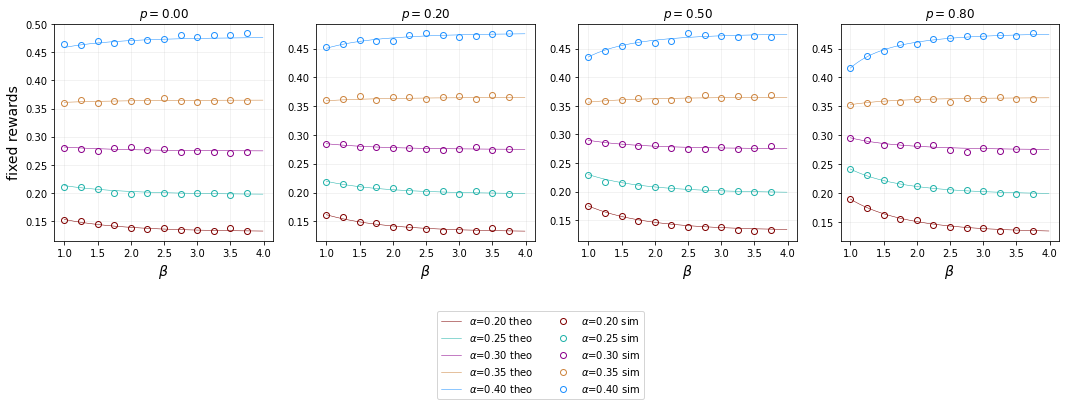

In [41]:
f, axarr = plt.subplots(ncols=4, figsize=(18,4))

colors = ['maroon', 'lightseagreen', 'darkmagenta', 'peru', 'dodgerblue'] 
handles, labels = [], []

for i in range(4):
    ax = axarr[i]
    for j, a in enumerate(alphas):
        line, = ax.plot(betas, theoRes[j,:,i], linewidth=0.5, color=colors[j], label=r'$\alpha$={:0.2f} theo'.format(a))
        if i == 0:
            handles.append(line)
            labels.append(r'$\alpha$={:0.2f} theo'.format(a))

for i in range(4):
    ax = axarr[i]
    for j, a in enumerate(alphas):
        marker, = ax.plot(simBetas, simsRes[j,:,i], marker='o', color=colors[j], linestyle='none', fillstyle='none',
                          label=r'$\alpha$={:0.2f} sim'.format(a))
        if i == 0:
            handles.append(marker)
            labels.append(r'$\alpha$={:0.2f} sim'.format(a))

        
for i, ax in enumerate(axarr):
    ax.grid(alpha=0.2)
    ax.set_xlabel(r'$\beta$', size=14)
    ax.set_title(r'$p=${:0.2f}'.format(ps[i]))

axarr[0].set_ylabel(r'fixed rewards', size=14)
f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# SIM for bernoulli reward

In [236]:
def p1Bernoulli(a, b, p, E):
    expr = 1/(a*p*(1-np.exp(-b+E))+a*(1-p)*(1-np.exp(-b)))
    return 1/(expr+1+(1-a)/(1-2*a))

def honestExtrasBernoulli(a, b, p, E):
    return honestBlocksBernoulli(a, b, p, E)

def attackExtrasBernoulli(a, b, p, E):
    num   = sp.exp(-b+E) + (1-sp.exp(-b+E))*(1-((1-a)**2))
    den   = (1-p)*(1-np.exp(-b)) + p*(1-np.exp(-b+E))
    expr1 = num / den
    expr2 = (1-a)*(a**3) / ((1-2*a)*((1-a)**2))
    expr3 = expr1 + a*(1-a) + a**2 + a/(1-a) + expr2
    return expr3

def extraRewBernoulli(a, b, p, E):
    A = attackExtrasBernoulli(a, b, p, E)
    H = honestExtrasBernoulli(a, b, p, E)
    return A/(A+H)

In [237]:
alphas = [0.2, 0.25, 0.3, 0.35, 0.4]
betas  = np.arange(1, 4, 0.01)
ps     = [0.2, 0.5, 0.8] # using E=1

In [238]:
theoRes = []
for a in alphas:
    temp1 = []
    for b in betas:
        temp2 = []
        for p in ps:
            temp2.append(extraRewBernoulli(a=a, b=b, p=p, E=1))
        temp1.append(temp2)
    theoRes.append(temp1)
theoRes = np.array(theoRes)
theoRes.shape

(5, 300, 3)

In [176]:
def simExtraRewardBernoulli(a, b, p, E, n):
    gamma = 0
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    honestBern = 0
    attackBern = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0
    prevBern   = 0
    for _ in range(n):
        attBlock = np.random.binomial(1, a)
        execRews = np.random.exponential()
        bernRews = np.random.binomial(1, p=p)
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if bernRews and execRews < (b-E):
                    state      = [1,0]
                    lastAttBlc = curTime
                    prevBern   = bernRews
                elif not bernRews and execRews < b:
                    state      = [1,0]
                    lastAttBlc = curTime
                    prevBern   = 0
                else:
                    attackBlcs += 1
                    attackRews += execRews
                    attackBern += bernRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1
                honestRews += execRews
                honestBern += bernRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
                attackBern += bernRews + prevBern
                prevBern   = 0
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                nextBern      = np.random.binomial(1, p=p)
                if sample < a:
                    attackBlcs += 2
                    attackRews += (curTime - lastState0) + nextExecRews
                    attackBern += (prevBern + nextBern)
                elif sample <= a + ((1-a)*gamma):
                    attackBlcs += 1
                    honestBlcs += 1
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                    attackBern += prevBern
                    honestBern += nextBern
                else:
                    honestBlcs += 2
                    honestRews += (curTime - lastState0) + nextExecRews
                    honestBern += (prevBern + nextBern)
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                prevBern    = 0
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]
            if state[0] < 2:
                raise KeyError("here")
            attackBern += (state[0]-2) * p * E
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, a)
            execRews = np.random.exponential()
            bernRews = np.random.binomial(1, p=p)
            curTime += execRews
            if attBlock:
                attackBlcs += 1
                attackRews += (remRews + execRews)
                attackBern += bernRews
            else:
                honestBlcs += 1
                honestRews += (remRews + execRews)
                honestBern += bernRews

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]
 
    return honestBern, attackBern

In [239]:
hB, aB = simExtraRewardBernoulli(a=0.35, b=2, p=0.5, E=1, n=int(1e5))
aB/(aB+hB)

0.374027669295214

In [144]:
p1 = p1Bernoulli(a=0.35, b=2, p=0.5, E=1)
aber = p1*attackExtrasBernoulli(a=0.35, b=2, p=0.5, E=1)*0.5
hber = p1*honestExtrasBernoulli(a=0.35, b=2, p=0.5, E=1)*0.5
aber, hber, aber / (aber+hber)

(0.14204589443808283, 0.2544257752747323, 0.3582750175844191)

In [241]:
extraRewBernoulli(a=0.35, b=2, p=0.5, E=1)

(0.564543233942371*exp(-1) + 1.87998710280486)/(0.564543233942371*exp(-1) + 5.43399582343067)

In [129]:
simBetas = np.arange(1, 4, 0.25)
simBetas

array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
       3.75])

In [130]:
simsRes = []
for a in alphas:
    temp1 = []
    for b in tqdm(simBetas):
        temp2 = []
        for p in ps:
            hb, ab = simExtraRewardBernoulli(a=a, b=b, p=p, E=1, n=int(1e5))
            temp2.append(ab/(ab+hb))
        temp1.append(temp2)
    simsRes.append(temp1)
simsRes = np.array(simsRes)
simsRes.shape

100%|██████████| 12/12 [00:20<00:00,  1.68s/it]


(5, 12, 3)

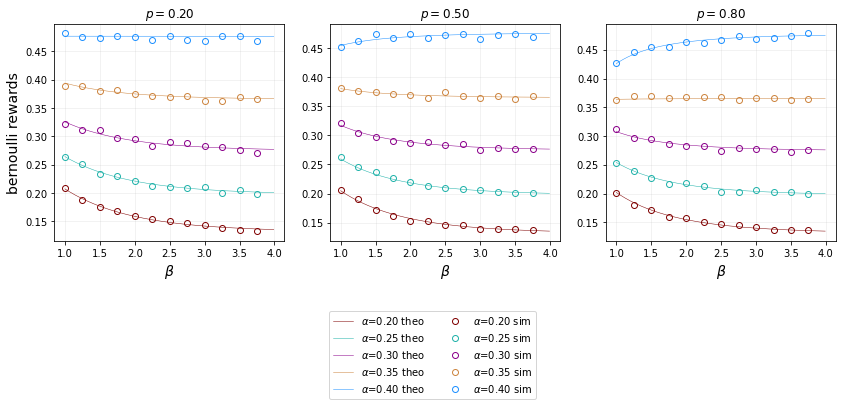

In [242]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

colors = ['maroon', 'lightseagreen', 'darkmagenta', 'peru', 'dodgerblue'] 
handles, labels = [], []

for i in range(3):
    ax = axarr[i]
    for j, a in enumerate(alphas):
        line, = ax.plot(betas, theoRes[j,:,i], linewidth=0.5, color=colors[j], 
                        label=r'$\alpha$={:0.2f} theo'.format(a))
        if i == 0:
            handles.append(line)
            labels.append(r'$\alpha$={:0.2f} theo'.format(a))

for i in range(3):
    ax = axarr[i]
    for j, a in enumerate(alphas):
        marker, = ax.plot(simBetas, simsRes[j,:,i], marker='o', color=colors[j], linestyle='none', 
                          fillstyle='none', label=r'$\alpha$={:0.2f} sim'.format(a))
        if i == 0:
            handles.append(marker)
            labels.append(r'$\alpha$={:0.2f} sim'.format(a))


for i, ax in enumerate(axarr):
    ax.grid(alpha=0.2)
    ax.set_xlabel(r'$\beta$', size=14)
    ax.set_title(r'$p=${:0.2f}'.format(ps[i]))

axarr[0].set_ylabel(r'bernoulli rewards', size=14)
f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

- trying to calc the probability that a given bernoulli reward ends up onchain

In [3]:
f0p0high = p1 / (1-sp.exp(-b)) * sp.integrate(sp.exp(-x), (x, b, sp.oo))
f0p0high

p_1*exp(-b)/(1 - exp(-b))

In [4]:
integrand = p1 * sp.exp(-x) * (sp.exp(-b+x) + a*(1-sp.exp(-b+x)) + (1-a)*(1-sp.exp(-b+x))*(a+(1-a)*g)) / (1-sp.exp(-b))
f0p0low = sp.integrate(integrand, (x,0,b))
f0p0low

b*(-a**2*g*p_1 + a**2*p_1 + 2*a*g*p_1 - 2*a*p_1 - g*p_1 + p_1)/(exp(b) - 1) + Piecewise((-(-a**2*g*p_1*exp(b) + a**2*p_1*exp(b) + 2*a*g*p_1*exp(b) - 2*a*p_1*exp(b) - g*p_1*exp(b))/(exp(b) - 1) + (-a**2*g*p_1*exp(b) + a**2*p_1*exp(b) + 2*a*g*p_1*exp(b) - 2*a*p_1*exp(b) - g*p_1*exp(b))*exp(-b)/(exp(b) - 1), Ne(b, 0)), (b*(-(-a**2*g*p_1 + a**2*p_1 + 2*a*g*p_1 - 2*a*p_1 - g*p_1 + p_1)/(exp(b) - 1) + (a**2*g*p_1*exp(b) - a**2*g*p_1 - a**2*p_1*exp(b) + a**2*p_1 - 2*a*g*p_1*exp(b) + 2*a*g*p_1 + 2*a*p_1*exp(b) - 2*a*p_1 + g*p_1*exp(b) - g*p_1 + p_1)/(exp(b) - 1)), True))

In [5]:
f0pp0p     = a*(1-a)*p1
f0ppp0pp   = a**2*p1
f1p1       = a*(2-a)*p1
fRestpRest = p1*2*(1-a)*a**2 / ((1-a)*(1-2*a))
fRestpRest

2*a**2*p_1/(1 - 2*a)

In [6]:
full = f0p0low + f0p0high + f0pp0p + f0ppp0pp + f1p1 + fRestpRest
full = sp.simplify(full)
full

Piecewise((-p_1*(2*a**2*(exp(b) - 1) + (2*a - 1)*(b*(a**2*g - a**2 - 2*a*g + 2*a + g - 1) - 1) - (2*a - 1)*(exp(b) - 1)*(a**2*g - 2*a*g - a*(a - 2) - a*(a - 1) + 2*a + g))/((2*a - 1)*(exp(b) - 1)), (b > 0) | (b < 0)), (-p_1*(2*a**2*(exp(b) - 1) + (2*a - 1)*(b*(a**2*g - a**2 - 2*a*g + 2*a + g - 1) - 1) + (2*a - 1)*(a*(1 - exp(b))*(3 - a) - b*(a**2*g - a**2 - 2*a*g + 2*a + g)*exp(b)))/((2*a - 1)*(exp(b) - 1)), True))

In [7]:
p0pp  = a*p1
p0p   = (1-a)*p1
p0    = p1 / (a*(1-sp.exp(-b)))
pRest = (1-a)*a/((1-a)*(1-2*a)) * p1

In [8]:
p1solved = sp.solve(sp.Eq(p0 + p0p + p0pp + p1 + pRest, 1), p1)[0]
p1solved

a*(2*a*exp(b) - 2*a - exp(b) + 1)/(3*a**2*exp(b) - 3*a**2 + 2*a - exp(b))

In [9]:
final = sp.simplify(full.evalf(subs={p1:p1solved}))
final

Piecewise((a*(-2.0*a**2*(exp(b) - 1) - (2.0*a - 1.0)*(b*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g - 1.0) - 1.0) + (2.0*a - 1.0)*(exp(b) - 1.0)*(a**2*g - 2.0*a*g - a*(a - 2.0) - a*(a - 1.0) + 2.0*a + g))*(2.0*a*exp(b) - 2.0*a - exp(b) + 1.0)/((2.0*a - 1.0)*(exp(b) - 1.0)*(3.0*a**2*exp(b) - 3.0*a**2 + 2.0*a - exp(b))), (b > 0) | (b < 0)), (-a*(2.0*a**2*(exp(b) - 1) + (2.0*a - 1.0)*(b*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g - 1.0) - 1.0) + (2.0*a - 1.0)*(a*(a - 3.0)*(exp(b) - 1.0) - b*(a**2*g - a**2 - 2.0*a*g + 2.0*a + g)*exp(b)))*(2.0*a*exp(b) - 2.0*a - exp(b) + 1.0)/((2.0*a - 1.0)*(exp(b) - 1.0)*(3.0*a**2*exp(b) - 3.0*a**2 + 2.0*a - exp(b))), True))

In [10]:
finalLambda = sp.lambdify((a, b, g), final)
finalLambda

<function _lambdifygenerated(a, b, g)>

In [11]:
def Carlsten(alpha, beta, gamma=0):
    num1 = 1 + (beta * np.power(1-alpha,2) * (1-gamma))
    den1 = np.exp(beta) - 1
    exp1 = num1 / den1
    
    exp2 = exp1 + (5 * alpha) + (np.power(1-alpha, 2) * gamma) 
    exp3 = (2 * np.power(alpha, 2)) / (1-2 * alpha) - (2 * np.power(alpha,2))
    
    exp4 = exp2 + exp3
    
    num2 = alpha * (1-2*alpha) * (1 - np.exp(-beta))
    den2 = 1 - 2 * np.exp(-beta) * alpha - 3 * (1 - np.exp(-beta)) * np.power(alpha,2)
    
    exp5 = num2 / den2
    
    return exp4 * exp5

In [16]:
alpha  = 0.33
betas  = np.arange(0.1, 10, 0.01)
gammas = [0., 0.5, 1.]

resMines = []
resTheir = []
for g in gammas:
    resMines.append(finalLambda(alpha, betas, g))
    resTheir.append(Carlsten(alpha, betas, g))

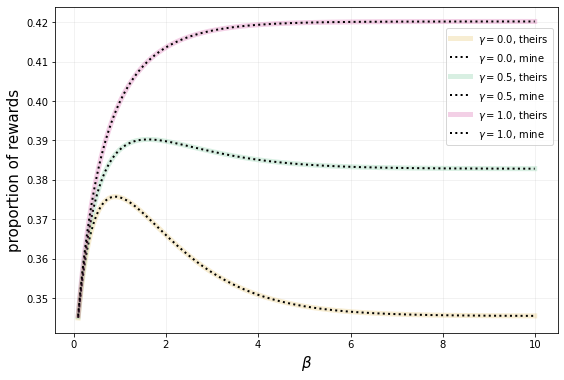

In [17]:
f, ax = plt.subplots(figsize=(9,6))

colors = ['goldenrod', 'mediumseagreen', 'mediumvioletred']
for i in [0, 1, 2]:
    ax.plot(betas, resTheir[i], color=colors[i], alpha=0.2,
            label='$\gamma={:0.1f}$, theirs'.format(gammas[i]), 
            linestyle='-', linewidth=5)
    ax.plot(betas, resMines[i], color='k', alpha=1, 
            label='$\gamma={:0.1f}$, mine'.format(gammas[i]),
            linestyle='dotted', linewidth=2)


ax.set_xlabel(r'$\beta$', size=15)
ax.set_ylabel(r'proportion of rewards', size=15)
ax.grid(alpha=0.2)
ax.legend(bbox_to_anchor=(1,.95))

# plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

In [227]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, E  = sp.symbols('a b x g p E')

In [229]:
# p1 
p1_solved = 1/(1/(a*p*(1-sp.exp(-b+E)) + a*(1-p)*sp.exp(-b)) + 1 + (1-a)/(1-2*a))
p1_solved

1/(1 + 1/(a*p*(1 - exp(E - b)) + a*(1 - p)*exp(-b)) + (1 - a)/(1 - 2*a))

In [235]:
p1_solved.evalf(subs={a:0.3, b:2., g:0.0, p:0.0, E:0.0})

0.0365227600574892

In [206]:
EXPR1 = (1-p) * (a*sp.exp(-b+x) + a**2*(1-sp.exp(-b+x))+ a*(1-a)*(1-sp.exp(-b+x))*(a+(1-a)*g))
EXPR1

(1 - p)*(a**2*(1 - exp(-b + x)) + a*(1 - a)*(1 - exp(-b + x))*(a + g*(1 - a)) + a*exp(-b + x))

In [207]:
EXPR2 = p * (a*sp.exp(-b+E+x)+a**2*(1-sp.exp(-b+E+x))+a*(1-a)*(1-sp.exp(-b+E+x))*(a+(1-a)*g))
EXPR2

p*(a**2*(1 - exp(E - b + x)) + a*(1 - a)*(1 - exp(E - b + x))*(a + g*(1 - a)) + a*exp(E - b + x))

In [208]:
p0 = p1 / (a*p*(1-sp.exp(-b+E))+a*(1-p)*(1-sp.exp(-b)))
p0

p_1/(a*p*(1 - exp(E - b)) + a*(1 - p)*(1 - exp(-b)))

In [209]:
lowIntegrand = sp.simplify(p0 *(EXPR1 + EXPR2)*sp.exp(-x))
lowIntegral  = sp.simplify(sp.integrate(lowIntegrand, (x, 0, b-E)))
lowIntegral

Piecewise((p_1*(-(E - b)*(a**2*g*p*exp(E) - a**2*g*p + a**2*g - a**2*p*exp(E) + a**2*p - a**2 - 2*a*g*p*exp(E) + 2*a*g*p - 2*a*g + 2*a*p*exp(E) - 2*a*p + 2*a + g*p*exp(E) - g*p + g - p*exp(E) + p - 1) + (-a**2*g + a**2 + 2*a*g - 2*a - g)*exp(b) + (a**2*g - a**2 - 2*a*g + 2*a + g)*exp(E))/(p*exp(E) - p - exp(b) + 1), Ne(-p*exp(E) + p + exp(b), 1)), (p_1*(E - b)*(-a**2*g*p*exp(E) + a**2*g*p + a**2*p*exp(E) - a**2*p + 2*a*g*p*exp(E) - 2*a*g*p - 2*a*p*exp(E) + 2*a*p - g*p*exp(E) + g*p + p*exp(E) - p + 1)/(p*exp(E) - p - exp(b) + 1), True))

In [210]:
medIntegrand = sp.simplify(p0 *(p*a + EXPR2)*sp.exp(-x))
medIntegral  = sp.simplify(sp.integrate(medIntegrand, (x, b-E, b)))
medIntegral

Piecewise((p*p_1*(a**2*g - a**2 - 2*a*g + 2*a + b*(a**2*g - a**2 - 2*a*g + 2*a + g - 1)*exp(E) + g + (E - b)*(a**2*g - a**2 - 2*a*g + 2*a + g - 1)*exp(E) + (-a**2*g + a**2 + 2*a*g - 2*a - g - 1)*exp(E) + 1)/(p*exp(E) - p - exp(b) + 1), Ne(-p*exp(E) + p + exp(b), 1)), (E*p*p_1*(a**2*g*exp(E) - a**2*g - a**2*exp(E) + a**2 - 2*a*g*exp(E) + 2*a*g + 2*a*exp(E) - 2*a + g*exp(E) - g - exp(E) - 1)/(p*exp(E) - p - exp(b) + 1), True))

In [211]:
highIntegrand = sp.simplify(p0*a*sp.exp(-x))
highIntegral  = sp.simplify(sp.integrate(highIntegrand, (x, b, sp.oo)))
highIntegral

Piecewise((-p_1/(p*exp(E) - p - exp(b) + 1), Ne(-p*exp(E) + p + exp(b), 1)), (Piecewise((nan, Eq(p_1/(p*exp(E) - p - exp(b) + 1), 0)), (p_1*(b*Abs(p_1/(p*exp(E) - p - exp(b) + 1)) - oo)/((p*exp(E) - p - exp(b) + 1)*Abs(p_1/(p*exp(E) - p - exp(b) + 1))), True)), True))

In [212]:
sp.simplify(lowIntegral + medIntegral + highIntegral)

Piecewise((p_1*(p*(a**2*g - a**2 - 2*a*g + 2*a + b*(a**2*g - a**2 - 2*a*g + 2*a + g - 1)*exp(E) + g + (E - b)*(a**2*g - a**2 - 2*a*g + 2*a + g - 1)*exp(E) + (-a**2*g + a**2 + 2*a*g - 2*a - g - 1)*exp(E) + 1) - (E - b)*(a**2*g*p*exp(E) - a**2*g*p + a**2*g - a**2*p*exp(E) + a**2*p - a**2 - 2*a*g*p*exp(E) + 2*a*g*p - 2*a*g + 2*a*p*exp(E) - 2*a*p + 2*a + g*p*exp(E) - g*p + g - p*exp(E) + p - 1) - (-a**2*g + a**2 + 2*a*g - 2*a - g)*exp(E) - (a**2*g - a**2 - 2*a*g + 2*a + g)*exp(b) - 1)/(p*exp(E) - p - exp(b) + 1), Ne(-p*exp(E) + p + exp(b), 1)), (nan, Eq(p_1/(p*exp(E) - p - exp(b) + 1), 0)), (p_1*(b*Abs(p_1/(p*exp(E) - p - exp(b) + 1)) + (-E*p*(-a**2*g*exp(E) + a**2*g + a**2*exp(E) - a**2 + 2*a*g*exp(E) - 2*a*g - 2*a*exp(E) + 2*a - g*exp(E) + g + exp(E) + 1) + (E - b)*(-a**2*g*p*exp(E) + a**2*g*p + a**2*p*exp(E) - a**2*p + 2*a*g*p*exp(E) - 2*a*g*p - 2*a*p*exp(E) + 2*a*p - g*p*exp(E) + g*p + p*exp(E) - p + 1))*Abs(p_1/(p*exp(E) - p - exp(b) + 1)) - oo)/((p*exp(E) - p - exp(b) + 1)*Abs(p_1/(p

In [213]:
out = sp.simplify(lowIntegral + medIntegral + highIntegral)

In [226]:
p1_solved = 1/(1/(a*(p*(1-sp.exp(-b+E)) + (1-p)*sp.exp(-b))) + 1 + (1-a)/(1-2*a))
p1_solved

1/(2.33333333333333 + 1/(0.160739988564793 - 0.00295995425917107*exp(E)))